In [ ]:
# import all libraries
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import jieba
import nltk
import re

In [ ]:
# read test and train data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test = test[test['label'] != 0.0]

Make sentences, list of lists of words of tweets

In [ ]:
sentence = []

for i in range(0,len(train)):
  list_of_words = [list(jieba.cut(elem))[0] for elem in re.sub("[^\w]", " ", train.iloc[i]['text']).split()]
  sentence.append(list_of_words)

In [ ]:
# train model
SIZE = 250
model = Word2Vec(sentence, min_count=1, size=SIZE)
embedings = model.wv

In [ ]:
def get_document_embedding(tweet, embeddings):
    '''
    Input:
        - tweet: tweet tokens
        - embeddings: a dictionary of word embeddings
    Output:
        - doc_embedding: sum of all word embeddings in the tweet
    '''
    doc_embedding = np.zeros(SIZE)
    for word in tweet:
      if word in list(model.wv.vocab.keys()):
        doc_embedding = doc_embedding + embedings[word]

    return doc_embedding

In [ ]:
def get_embedding_matrix(data):
  '''
  Input:
    - data : dataframe, input data

  Output:
    - embedding_matrix

    '''

  embedding_matrix = np.zeros((len(data),SIZE))

  for i in range(0,len(data)):
    list_of_words = [list(jieba.cut(elem))[0] for elem in re.sub("[^\w]", " ", data.iloc[i]['text']).split()]
    embedding_matrix[i,:] = get_document_embedding(list_of_words, embedings)
  return embedding_matrix

In [ ]:
# suffle data into folds for crossvalidation
train = shuffle(train)
train['fold'] = np.arange(0,len(train))
train

,text,label,language,fold
5884,@user Evidentemente la signora li ha provati t...,3.8,Italian,0
9377,@user 哈哈难道要求太高？🤣,3.0,Chinese,1
2124,"@user vamos a ulises, un baile como la gente",2.0,Spanish,2
4373,@user que nenhum dele pro teu time não ?? vou ...,3.0,Portuguese,3
7059,Doja elle insulte ses fans et 10 mins après el...,1.8,French,4
...,...,...,...,...
6537,J’aime tellement mes copines putain,2.8,French,9486
5670,Fiori raccolti nel giardino della mia fantasia...,2.6,Italian,9487
5715,@user Che faceva le cose brutte,1.6,Italian,9488
165,@user @user I was worried it was a broken jar ...,2.0,English,9489


In [ ]:
x_train = get_embedding_matrix(train)
x_test = get_embedding_matrix(test)

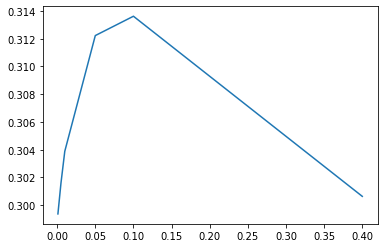

In [ ]:
cor_coef_train = []
cor_coef_validate = []
alpha = [0.001, 0.005, 0.01, 0.05, 0.1, 0.4]

# crossvalidation folds
step = np.floor(len(train)/5)

for a in alpha: # optimize model over regularization coeficient
  error_train = 0
  error_validate = 0

  for k in range(0,5): # k-fold
    # Classifier:
    #clf = LinearRegression()
    clf = Ridge(alpha = a)
    trainfeatures = x_train[train['fold'] % 5 != k]
    validatefeatures = x_train[train['fold'] % 5 == k]
    clf.fit(trainfeatures, train[train['fold'] % 5 != k]['label'])

    # train results
    results = clf.predict(trainfeatures)
    error_train += np.corrcoef(train[train['fold'] % 5 != k]['label'], results)[0,1]

    # validation results
    results = clf.predict(validatefeatures)
    error_validate += np.corrcoef(train[train['fold'] % 5 == k]['label'], results)[0,1]

  cor_coef_train.append(error_train/5)
  cor_coef_validate.append(error_validate/5)

#plt.plot(alpha, cor_coef_train)
plt.plot(alpha, cor_coef_validate)

In [ ]:
# train the model with optimal hyper-paremeters
clf = Ridge(alpha = alpha[np.argmax(cor_coef_validate)])
clf.fit(x_train, train['label'])
test['predictions'] = clf.predict(x_test)

English 0.3215936425620462
Spanish 0.4680843377628167
Portuguese 0.31889682230409544
Italian 0.1988325465323242
French 0.29919509388911386
Chinese 0.022022917118412873
Hindi 0.1936075627447453
Dutch 0.13685297702142132
Korean 0.04654023613494756
Arabic 0.16134384303806368
Overall 0.25379441739093617
Seen Languages 0.3100677191484831
Unseen Languages 0.22341080278984232
0.32159 & 0.46808 & 0.31890 & 0.19883 & 0.29920 & 0.02202 & 0.19361 & 0.13685 & 0.04654 & 0.16134
0.25379 & 0.31007 & 0.22341


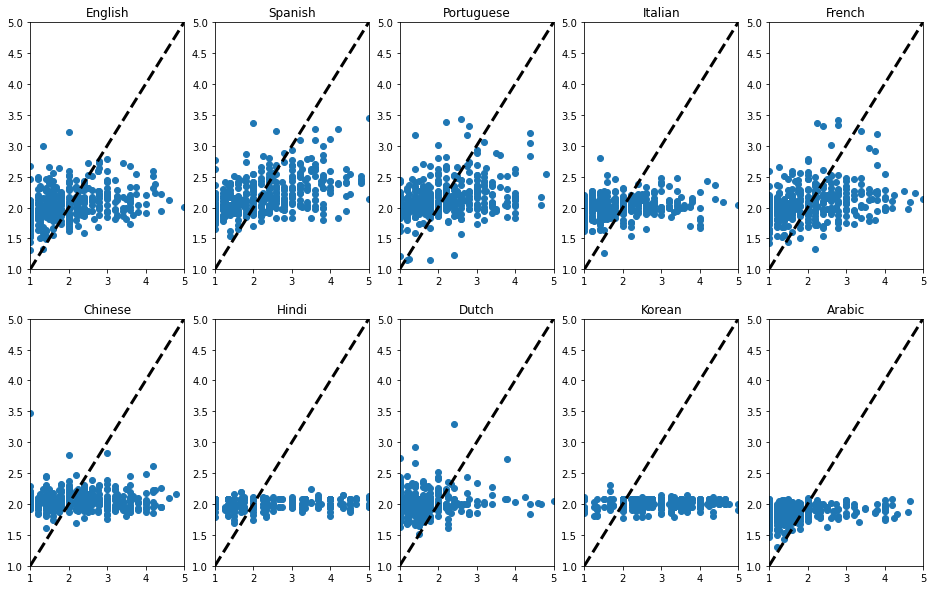

In [ ]:
languages = ['English', 'Spanish', 'Portuguese', 'Italian', 'French', 'Chinese','Hindi', 'Dutch', 'Korean', 'Arabic']
corr = []

f = plt.figure()
f.set_figwidth(16)
f.set_figheight(10)
i = 1

# represent data in different languages
for language in languages:
  ind = (test['language'] == language).values
  plt.subplot(2,5,i)
  plt.scatter(test[ind]['label'], test[ind]['predictions'])
  error = np.corrcoef(test[ind]['label'], test[ind]['predictions'])[0,1]
  plt.title(language)
  print(language + ' ' + str(error))
  plt.xlim([1,5])
  plt.ylim([1,5])
  xpoints = ypoints = plt.xlim()
  plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
  i += 1
  corr.append(error)

overall = []
error = test['predictions'].corr(test['label'])
overall.append(error)
print('Overall', error)

s_df = test[test['language'].isin(['English', 'Spanish', 'Portuguese', 'Italian', 'French', 'Chinese'])]
error = s_df['predictions'].corr(s_df['label'])
overall.append(error)
print('Seen Languages',error)

u_df = test[test['language'].isin(['Hindi', 'Dutch', 'Korean', 'Arabic'])]
error = u_df['predictions'].corr(u_df['label'])
overall.append(error)
print('Unseen Languages',error)

print(' & '.join('{:0.5f}'.format(i) for i in corr))
print(' & '.join('{:0.5f}'.format(i) for i in overall))

In [ ]:
# save data
test['word2vec'] = test['predictions']
test.to_csv('groundtruth.csv', index=False)

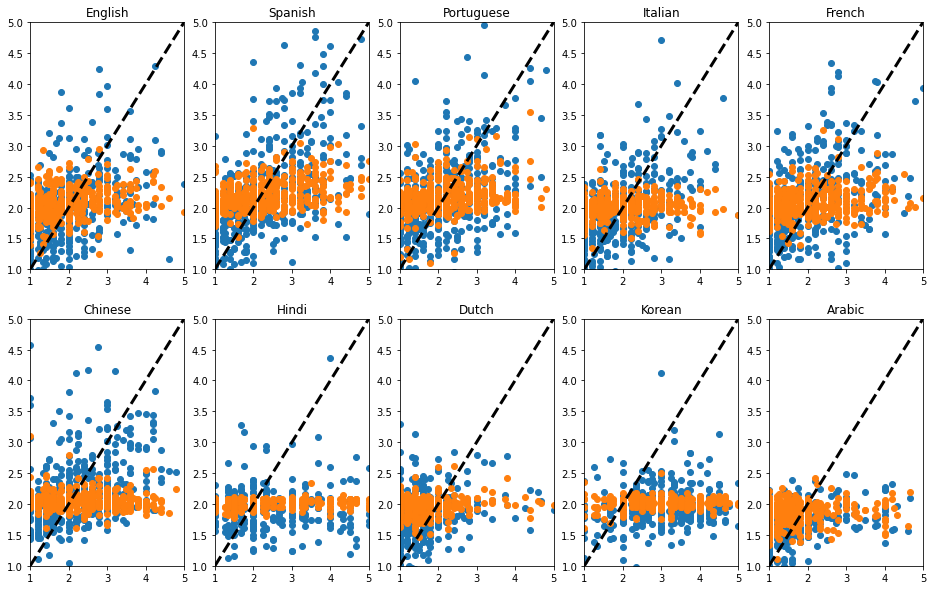

In [ ]:
# plot data
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(10)
i = 1

for language in languages:
  ind = (test['language'] == language).values
  plt.subplot(2,5,i)
  plt.scatter(test[ind]['label'], test[ind]['bof'])
  plt.scatter(test[ind]['label'], test[ind]['word2vec'])
  error = np.corrcoef(test[ind]['label'], test[ind]['predictions'])[0,1]
  plt.title(language)
  plt.xlim([1,5])
  plt.ylim([1,5])
  xpoints = ypoints = plt.xlim()
  plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
  i += 1

In [ ]:
def compute_pca(X, n_components: int=2):
    """Calculate the principal components for X

    Args:
       X: of dimension (m,n) where each row corresponds to a word vector
       n_components: Number of components you want to keep.

    Return:
       X_reduced: data transformed in 2 dims/columns + regenerated original data
    """
    # you need to set axis to 0 or it will calculate the mean of the entire matrix instead of one per row
    X_demeaned = X - X.mean(axis=0)

    # calculate the covariance matrix
    # the default numpy.cov assumes the rows are variables, not columns so set rowvar to False
    covariance_matrix = np.cov(X_demeaned, rowvar=False)

    # calculate eigenvectors & eigenvalues of the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix)

    # sort eigenvalue in increasing order (get the indices from the sort)
    idx_sorted = np.argsort(eigen_vals)

    # reverse the order so that it's from highest to lowest.
    idx_sorted_decreasing = list(reversed(idx_sorted))

    # sort the eigen values by idx_sorted_decreasing
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]

    # sort eigenvectors using the idx_sorted_decreasing indices
    # We're only sorting the columns so remember to get all the rows in the slice
    eigen_vecs_sorted = eigen_vecs[:, idx_sorted_decreasing]

    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    # once again, make sure to get all the rows and only slice the columns
    eigen_vecs_subset = eigen_vecs_sorted[:, :n_components]

    # transform the data by multiplying the transpose of the eigenvectors
    # with the transpose of the de-meaned data
    # Then take the transpose of that product.
    X_reduced = np.dot(eigen_vecs_subset.T, X_demeaned.T).T
    return X_reduced

In [ ]:
reduced_coordinates = compute_pca(x_test)

Text(0, 0.5, 'druga koordinata')

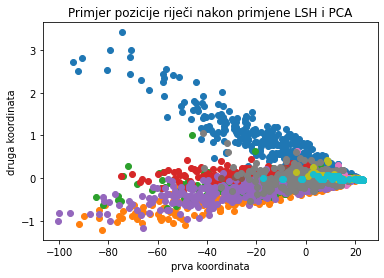

In [ ]:
from pickle import POP_MARK
fig, ax = plt.subplots()
#plt.xlim([0.25,0.45])
#plt.ylim([-0.05,0.05])

for language in languages:
  pom = reduced_coordinates[test['language']==language]
  pom2 = test[test['language']==language]
  ax.scatter(pom[:,0], pom[:,1])
#  ax.annotate(pom2.iloc[10:15]['label'].values, (pom[10:15,0]-0.001,pom[10:15,1]-0.001))

plt.title('Primjer pozicije riječi nakon primjene LSH i PCA')
plt.xlabel('prva koordinata')
plt.ylabel('druga koordinata')
